Aggregation, Filtering and Dispersion Tests
==

Decaying Tracer
--

The tuning process is going to attempt to capture spring-neap variability, and so we need
a more continuous-in-time metric of how the dispersion compares.  This notebook
develops tests where decaying tracers are input to the system, and then we can 
compare, over time and space, the fidelity of each model relative to the original.


In [2]:
# Quiet some of the logging
# workaround via specifying an invalid value first
%config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
%config Application.log_level='INFO'
import logging
logging.getLogger().setLevel(logging.INFO)
log = logging.getLogger()
log.debug('Test debug')
log.info('Test info')
log.warning('Test warn')

ERROR:root:The 'log_level' trait of an IPKernelApp instance must be any of (0, 10, 20, 30, 40, 50, 'DEBUG', 'INFO', 'WARN', 'ERROR', 'CRITICAL'), but a value of 'WORKAROUND' <class 'str'> was specified.
INFO:root:Test info


In [3]:
import matplotlib.pyplot as plt
from matplotlib import colors
from shapely import geometry, wkt
import stompy.plot.cmap as scmap
import xarray as xr
from stompy.grid import unstructured_grid
import numpy as np
import pandas as pd
import stompy.model.delft.waq_scenario as dwaq
import logging as log
from stompy import utils
from stompy.plot import plot_wkb
import netCDF4
import warnings
from stompy.model.data_comparison import calc_metrics
import os
import six
from matplotlib import gridspec
%matplotlib inline

In [4]:
import tracer_common as tc
six.moves.reload_module(tc)

<module 'tracer_common' from '/hpcvol1/rusty/dwaq/agg_wy2013/tracer_tests/tracer_common.py'>

In [5]:
cmap=scmap.load_gradient('turbo.cpt') # a less offensive 'jet'

In [6]:
# Narrowed down to just the two runs that we've actually been using
hydro_orig=dwaq.HydroFiles("/hpcvol1/public/sfb_dfm_v2/wy2013c/DFM_DELWAQ_wy2013c_adj/wy2013c.hyd")
hydro_orig.name='orig'
hydro_agg141_lp=dwaq.HydroFiles("../../agg141-lp/com-wy2013c-agg141-lp.hyd")
hydro_agg141_lp.name='agg141_lp'

hydro_agg141=dwaq.HydroFiles("../../agg141/com-wy2013c-agg141.hyd")
hydro_agg141.name='agg141'

Continuous Release
==

Unlike the tests above, here the tracer source is a point with a continuous
mass-per-time discharge. So far it runs, but no analysis yet. One avenue
for analysis is to run release for 15-25 days, and compare the spatial
distribution of the resulting plumes. For qualitative comparison that's
straightforward. To get quantitative, it may be most appropriate to 
average the output from the original grid onto the aggregated grid, then
evaluate how close the two sets of concentrations are.

In [7]:
runs=[]
for hydro in [hydro_agg141_lp,
              hydro_orig # Takes a while.
             ]:
    run=tc.DecayingPlume(hydro=hydro,force=False)
    run.run_waq_model()
    runs.append( run )

INFO:root:base_path defaults to run_agg141_lp_tripleDecay
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_orig_tripleDecay
INFO:root:Run seems to exist -- will not run again


In [8]:
# Aggregate output from the original run to the time and spatial scales of the agg
# run for evaluation of the dispersion coefficients.
agg_run=runs[0]
orig_run=runs[1]

# Get the aggregated geometry:
agg_grid=agg_run.hydro.grid()

# The data to be aggregated
orig_map_ds=orig_run.wm.map_ds()

In [9]:
orig_tracers=tc.agg_decay_tracers(orig_run.wm,force=False)
agg_tracers= tc.agg_decay_tracers(agg_run.wm,force=False)

In [25]:
six.moves.reload_module(tc)

<module 'tracer_common' from '/hpcvol1/rusty/dwaq/agg_wy2013/tracer_tests/tracer_common.py'>

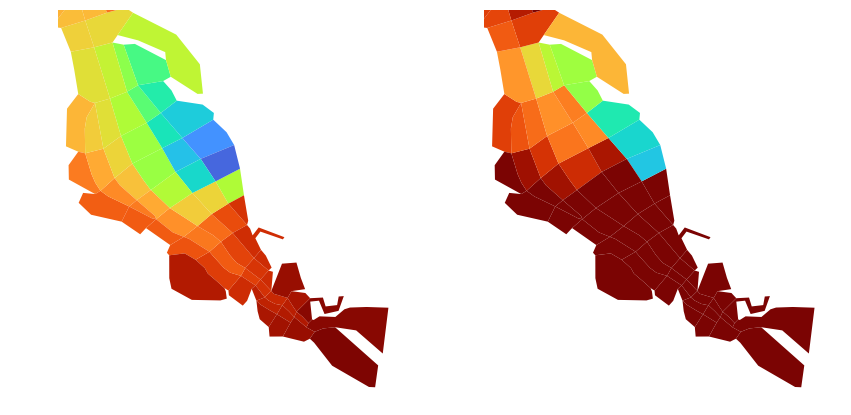

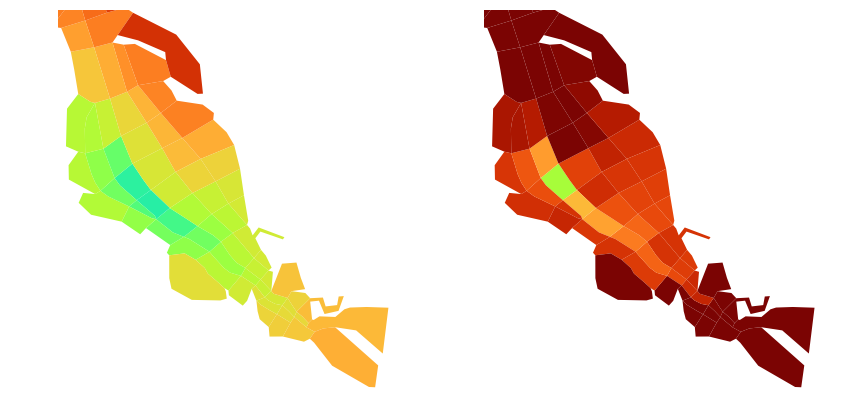

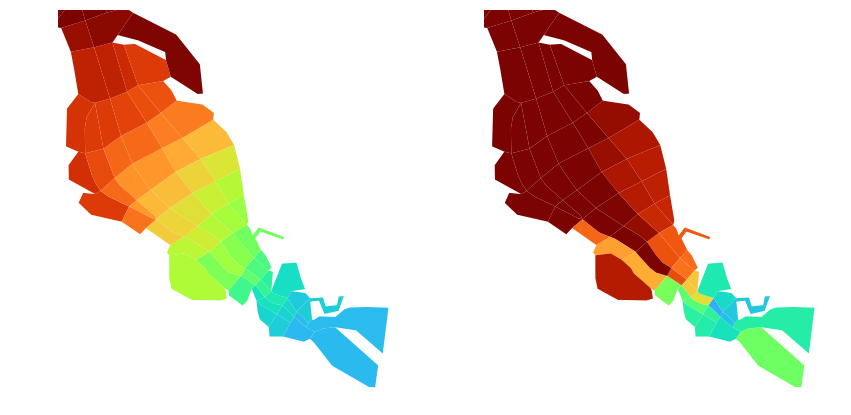

In [10]:
for tr in range(3):
    fig,axs=plt.subplots(1,2,figsize=(14,7))
    for ax,tracers in zip(axs,[orig_tracers,agg_tracers]):
        agg_grid.plot_cells(values=tracers['age%d'%(1+tr)].isel(time=-1),
                            cmap=cmap,clim=[0,40],ax=ax)
        ax.axis(tc.DecayingPlume.zoom) 
        ax.axis('off') 

In [18]:
# Parameters controlling the calculation of skill metrics
cell_sel=agg_grid.cell_clip_mask(tc.DecayingPlume.zoom) # limit to the cells in South Bay
# start at 1500 for spinup allowance.
# note that the run doesn't appear to be fully spunup
# even by 80 days, but hopefully most of the remaining
# spinup is outside south bay 
t_slc=slice(1500,-1,4) # used to be stride of 100, but that's 50 hours.  no good.
ages=['age1','age2','age3']

In [28]:
six.moves.reload_module(tc)
tc.decay_metrics(agg_tracers,orig_tracers,t_slc,cell_sel)

{'amp': 0.26828421047337825,
 'bias': -11.828596962492455,
 'murphy': -3.0328343274316496,
 'nan_fraction': 0.0,
 'r': 0.63658615782284711,
 'spearman_p': 0.0,
 'spearman_rho': 0.60732608073321537,
 'wilmott': 0.47230807186091978}

In [29]:
# next layer of the onion -- scan parameters with just a spatially/temporally
# constant base_x_dispersion.

rows=[]

for K in [0,50,100,150,200,250,300,400,500,700,1000]:
    run=tc.DecayingPlume(hydro=hydro_agg141_lp,base_x_dispersion=K)
    run.run_waq_model()
    agg_tracers=tc.agg_decay_tracers(run.wm,force=False)
    score = tc.decay_metrics(agg_tracers,orig_tracers,t_slc,cell_sel)
    score['K']=K
    rows.append( score )

INFO:root:base_path defaults to run_agg141_lp_tripleDecay
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx50
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx100
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx150
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx200
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx250
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx300
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx400
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx500
INFO:root:Run seems to 

In [30]:
pd.DataFrame(rows)

,K,amp,bias,murphy,nan_fraction,r,spearman_p,spearman_rho,wilmott
0,0,1.502066,7.660176,-1.382620,0.0,0.872950,0.0,0.876040,0.734705
1,50,1.209339,4.067933,-0.081004,0.0,0.902053,0.0,0.906799,0.842903
2,100,1.027280,1.855423,0.402110,0.0,0.879498,0.0,0.881762,0.874121
3,150,0.888211,0.027294,0.597200,0.0,0.864105,0.0,0.864484,0.878573
4,200,0.778750,-1.512019,0.608643,0.0,0.852865,0.0,0.851613,0.861415
5,250,0.691081,-2.828454,0.503792,0.0,0.843316,0.0,0.840543,0.827887
6,300,0.619893,-3.969469,0.326336,0.0,0.834066,0.0,0.829464,0.783347
7,400,0.512882,-5.854505,-0.142829,0.0,0.813799,0.0,0.806233,0.687239
8,500,0.437916,-7.352628,-0.670249,0.0,0.789613,0.0,0.778463,0.617735
9,700,0.343195,-9.591969,-1.707636,0.0,0.731026,0.0,0.711742,0.535016


Scaling Dispersion from Tidal--Nontidal Difference
--

As a halfway point between (a) a direct calculation of what the dispersion 
coefficient "should" be, and (b) prescribing anisotropic dispersion coefficients
through blind optimization, there is a middle ground of correlating
dispersion with features of the hydrodynamics. This section looks at
the feasibility of using the difference between the tidal and non-tidal
advective fluxes as a predictor of dispersion coefficient.

The scaling here is important. Fluxes are m$^3$/s, and dispersion coefficients
are m$^2$/s.

As a thought experiment, consider a case where each tidal cycle
leads to a net exchange of 10% of the volume between two control
volumes of equal size. In a subtidal representation of this system,
that flux is the product of the difference in concentrations, the
area of their common face, and divided by the length between them.

If we assume that the dispersive flux should scale with the rms
tidal flux, then to get the corresponding dispersion coefficient we
scale rms flux by length/area.

Overall, the approach is promising, and with tuning a single
parameter it comes close to performing as well as the Kxy approach
which required 2-3 parameters (and even then, the parameters are
specific to the 3 test regions).

In [45]:
rows2=[]

for K_scale in [0.0,0.01,0.02,0.05,0.08,0.10,0.12,0.15,0.20]:
    run=tc.DecayingPlumeKauto(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=K_scale)
    run.run_waq_model()
    agg_tracers= tc.agg_decay_tracers(run.wm,force=False)
    score = tc.decay_metrics(agg_tracers,orig_tracers,t_slc=t_slc,cell_sel=cell_sel)
    score['K_scale']=K_scale
    print("K=%g: score=%.4f"%(K_scale,score['wilmott']))
    rows2.append( score )

INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.01
INFO:root:Run seems to exist -- will not run again


K=0: score=0.7347


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.02
INFO:root:Run seems to exist -- will not run again


K=0.01: score=0.7880


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.05
INFO:root:Run seems to exist -- will not run again


K=0.02: score=0.8281


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.08
INFO:root:Run seems to exist -- will not run again


K=0.05: score=0.9113


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.1
INFO:root:Run seems to exist -- will not run again


K=0.08: score=0.9588


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.12
INFO:root:Run seems to exist -- will not run again


K=0.1: score=0.9727


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.15
INFO:root:Run seems to exist -- will not run again


K=0.12: score=0.9728


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.2
INFO:root:Run seems to exist -- will not run again


K=0.15: score=0.9489
K=0.2: score=0.8661


In [46]:
pd.DataFrame(rows2).sort_values('murphy')

,K_scale,amp,bias,murphy,nan_fraction,r,spearman_p,spearman_rho,wilmott
0,0.00,1.502066,7.660176,-1.382620,0.0,0.872950,0.0,0.876040,0.734705
1,0.01,1.402809,6.288868,-0.656405,0.0,0.902296,0.0,0.906336,0.788046
2,0.02,1.326754,5.258322,-0.205431,0.0,0.919225,0.0,0.923353,0.828069
3,0.05,1.157519,2.971194,0.518639,0.0,0.946592,0.0,0.950941,0.911344
8,0.20,0.714417,-3.704393,0.560926,0.0,0.964880,0.0,0.967951,0.866091
4,0.08,1.031619,1.220566,0.818814,0.0,0.959663,0.0,0.963719,0.958786
7,0.15,0.820970,-1.935255,0.832222,0.0,0.968358,0.0,0.971825,0.948873
5,0.10,0.961818,0.213827,0.894938,0.0,0.964451,0.0,0.968337,0.972736
6,0.12,0.900426,-0.700905,0.905044,0.0,0.967164,0.0,0.970869,0.972772


Results so far related to Decaying Tracers and infered dispersion
==

Comparing the spatial and temporal distribution of a decaying tracer, and specifically
an age tracer, appears promising for evaluating parameterizations of dispersion in 
the aggregated model.

There is evidence that the vertical dispersion coefficients have retained their
tidal variability and that does alter the output of the model.  To date, this has
not been filtered out. That said, tests with decay tracers did not show
sensitivity to reducing vertical dispersion (i.e. water age time series with
ScaleVDisp=1.0 are not appreciably different than ScaleVDisp=0.1)

When decaying tracers are used to evaluate spatially and temporally constant
dispersion coefficients, we arrive at similar values as before, roughly 200 m$^2$/s.
Tests have been using three age tracers, representing a shoal source, a channel
source, and a Lower South Bay source. A constant dispersion coefficient of 200 m$^2$/s
leads to a Murphy skill score of 0.596, and a Wilmott skill score of 0.855 (the optimal 
K for the Wilmott score is closer to 100 than 200, but the Murphy score is generally 
thought of as more reliable than Wilmott).

A constant in time, but spatially and directionlly variable dispersion coefficient
is able to achieve a Murphy score of 0.867 and Wilmott score of 0.964.  This 
method compares tidal fluxes with the non-tidal fluxes, and scales the local exchange
coefficient based on their ratio.

Extending this concept to time-varying coefficients introduces one more parameter -- 
the time scale for averaging.  While previous tests showed
that spring-neap variations were significant, no additional skill is achieved
with this approach. Comparing time series of age, there is significant spring-neap
variation in all of the aggregated runs, suggesting that changes in residual circulation
are enough to change dispersion. In neither the constant nor the varying $K$ case 
are the spring-neap variations in age as large as they are in the high resolution
run.

In order to test whether even more time variability in $K$ is needed, additional
runs used a $K$ that was "amplified" around its time average by factors of 2 and 4.
These runs showed no improvement in skill, though the age time series are noisier.




In [43]:
rows3=[]

for lowpass_days in [6,10,14,21]:
    for K_scale in [0.08,0.10,0.12,0.15]: # [0.0,0.01,0.02,0.05,0.1,0.15,0.20]:
        run=tc.DecayingPlumeKautoUnsteady(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=K_scale,
                                          lowpass_days=lowpass_days,force=False)
        run.run_waq_model()
        agg_tracers= tc.agg_decay_tracers(run.wm,force=run.force)
        score = tc.decay_metrics(agg_tracers,orig_tracers,t_slc=t_slc,cell_sel=cell_sel)
        score['K_scale']=K_scale
        score['lp_days']=lowpass_days
        print("K=%g: score=%.4f"%(K_scale,score['wilmott']))
        rows3.append( score )

INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.08-6d
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.1-6d
INFO:root:Run seems to exist -- will not run again


K=0.08: score=0.9550


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-6d
INFO:root:Run seems to exist -- will not run again


K=0.1: score=0.9708


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.15-6d
INFO:root:Run seems to exist -- will not run again


K=0.12: score=0.9738


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.08-10d
INFO:root:Run seems to exist -- will not run again


K=0.15: score=0.9554


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.1-10d
INFO:root:Run seems to exist -- will not run again


K=0.08: score=0.9557


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-10d
INFO:root:Run seems to exist -- will not run again


K=0.1: score=0.9712


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.15-10d
INFO:root:Run seems to exist -- will not run again


K=0.12: score=0.9736


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.08-14d
INFO:root:Run seems to exist -- will not run again


K=0.15: score=0.9542


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.1-14d
INFO:root:Run seems to exist -- will not run again


K=0.08: score=0.9559


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-14d
INFO:root:Run seems to exist -- will not run again


K=0.1: score=0.9713


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.15-14d
INFO:root:Run seems to exist -- will not run again


K=0.12: score=0.9735


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.08-21d
INFO:root:Run seems to exist -- will not run again


K=0.15: score=0.9538


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.1-21d
INFO:root:Run seems to exist -- will not run again


K=0.08: score=0.9562


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-21d
INFO:root:Run seems to exist -- will not run again


K=0.1: score=0.9715


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.15-21d
INFO:root:Run seems to exist -- will not run again


K=0.12: score=0.9735
K=0.15: score=0.9532


In [44]:
pd.DataFrame(rows3).sort_values('murphy')

,K_scale,amp,bias,lp_days,murphy,nan_fraction,r,spearman_p,spearman_rho,wilmott
0,0.08,1.044222,1.396731,6,0.797480,0.0,0.958457,0.0,0.962685,0.954965
4,0.08,1.042060,1.360198,10,0.801784,0.0,0.958605,0.0,0.962745,0.955736
8,0.08,1.041223,1.353228,14,0.802742,0.0,0.958664,0.0,0.962832,0.955885
12,0.08,1.040101,1.338592,21,0.804633,0.0,0.958794,0.0,0.962971,0.956231
15,0.15,0.830819,-1.781647,21,0.845833,0.0,0.968071,0.0,0.971650,0.953232
11,0.15,0.832203,-1.760480,14,0.847584,0.0,0.967995,0.0,0.971562,0.953796
7,0.15,0.833297,-1.749103,10,0.848751,0.0,0.967993,0.0,0.971562,0.954191
3,0.15,0.835840,-1.704030,6,0.852473,0.0,0.967946,0.0,0.971616,0.955373
1,0.10,0.975450,0.409760,6,0.884643,0.0,0.963425,0.0,0.967488,0.970830
5,0.10,0.973129,0.370139,10,0.886707,0.0,0.963544,0.0,0.967520,0.971215


In [47]:
pd.DataFrame(rows2).sort_values('murphy')

,K_scale,amp,bias,murphy,nan_fraction,r,spearman_p,spearman_rho,wilmott
0,0.00,1.502066,7.660176,-1.382620,0.0,0.872950,0.0,0.876040,0.734705
1,0.01,1.402809,6.288868,-0.656405,0.0,0.902296,0.0,0.906336,0.788046
2,0.02,1.326754,5.258322,-0.205431,0.0,0.919225,0.0,0.923353,0.828069
3,0.05,1.157519,2.971194,0.518639,0.0,0.946592,0.0,0.950941,0.911344
8,0.20,0.714417,-3.704393,0.560926,0.0,0.964880,0.0,0.967951,0.866091
4,0.08,1.031619,1.220566,0.818814,0.0,0.959663,0.0,0.963719,0.958786
7,0.15,0.820970,-1.935255,0.832222,0.0,0.968358,0.0,0.971825,0.948873
5,0.10,0.961818,0.213827,0.894938,0.0,0.964451,0.0,0.968337,0.972736
6,0.12,0.900426,-0.700905,0.905044,0.0,0.967164,0.0,0.970869,0.972772


In [179]:
# If wilmott is used -- the best of the new runs has wilmott=0.964233, K_scale=0.12 and lp_days=6
# Compare that to the constant case, 0.10, wilmott=0.964459. Possible that would be even a bit
# better with a more tuned K_scale.

# What about Murphy? similar -- new runs slightly better but with a bigger K_scale may
# be just the same.

# Need to pry a bit to see why the spring-neap isn't helping.

In [34]:
run_const=tc.DecayingPlumeKauto(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=0.12,
                                force=False)
run_zero=tc.DecayingPlumeKauto(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=0.0,
                               force=False)
run_var=tc.DecayingPlumeKautoUnsteady(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=0.12,
                                      lowpass_days=6,force=False)

INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.12
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-6d


In [35]:
run=tc.DecayingPlumeKautoUnsteady(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=0.12,
                                  lowpass_days=6,amp_factor=2.0,force=False)
run.run_waq_model()
agg_tracers=tc.agg_decay_tracers(run.wm,force=run.force)
score = tc.decay_metrics(agg_tracers,orig_tracers,t_slc=t_slc,cell_sel=cell_sel)
run_amp=run
score

INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-6d-2x
INFO:root:Run seems to exist -- will not run again


{'amp': 0.90737681045991947,
 'bias': -0.59914265843127568,
 'murphy': 0.9046698069961483,
 'nan_fraction': 0.0,
 'r': 0.96597751155834832,
 'spearman_p': 0.0,
 'spearman_rho': 0.9699055499545457,
 'wilmott': 0.9729022651964625}

In [36]:
run=tc.DecayingPlumeKauto(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=0.12,
                          scale_v_disp=0.1,force=False)
run.run_waq_model()
agg_tracers=tc.agg_decay_tracers(run.wm,force=run.force)
score = tc.decay_metrics(agg_tracers,orig_tracers,t_slc=t_slc,cell_sel=cell_sel)
run_lowKz=run
score

INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kz0.1_Kauto0.12
INFO:root:Run seems to exist -- will not run again


{'amp': 0.85847549671628398,
 'bias': -1.3093967408508216,
 'murphy': 0.88220363006395264,
 'nan_fraction': 0.0,
 'r': 0.96794556433991519,
 'spearman_p': 0.0,
 'spearman_rho': 0.97192496847221488,
 'wilmott': 0.96519949179240383}

In [39]:
tracers=[]
for run in [run_const,run_var]:
    run.run_waq_model()
    agg_tracers= tc.agg_decay_tracers(run.wm,force=run.force)
    tracers.append(agg_tracers)

INFO:root:Run seems to exist -- will not run again
INFO:root:Run seems to exist -- will not run again


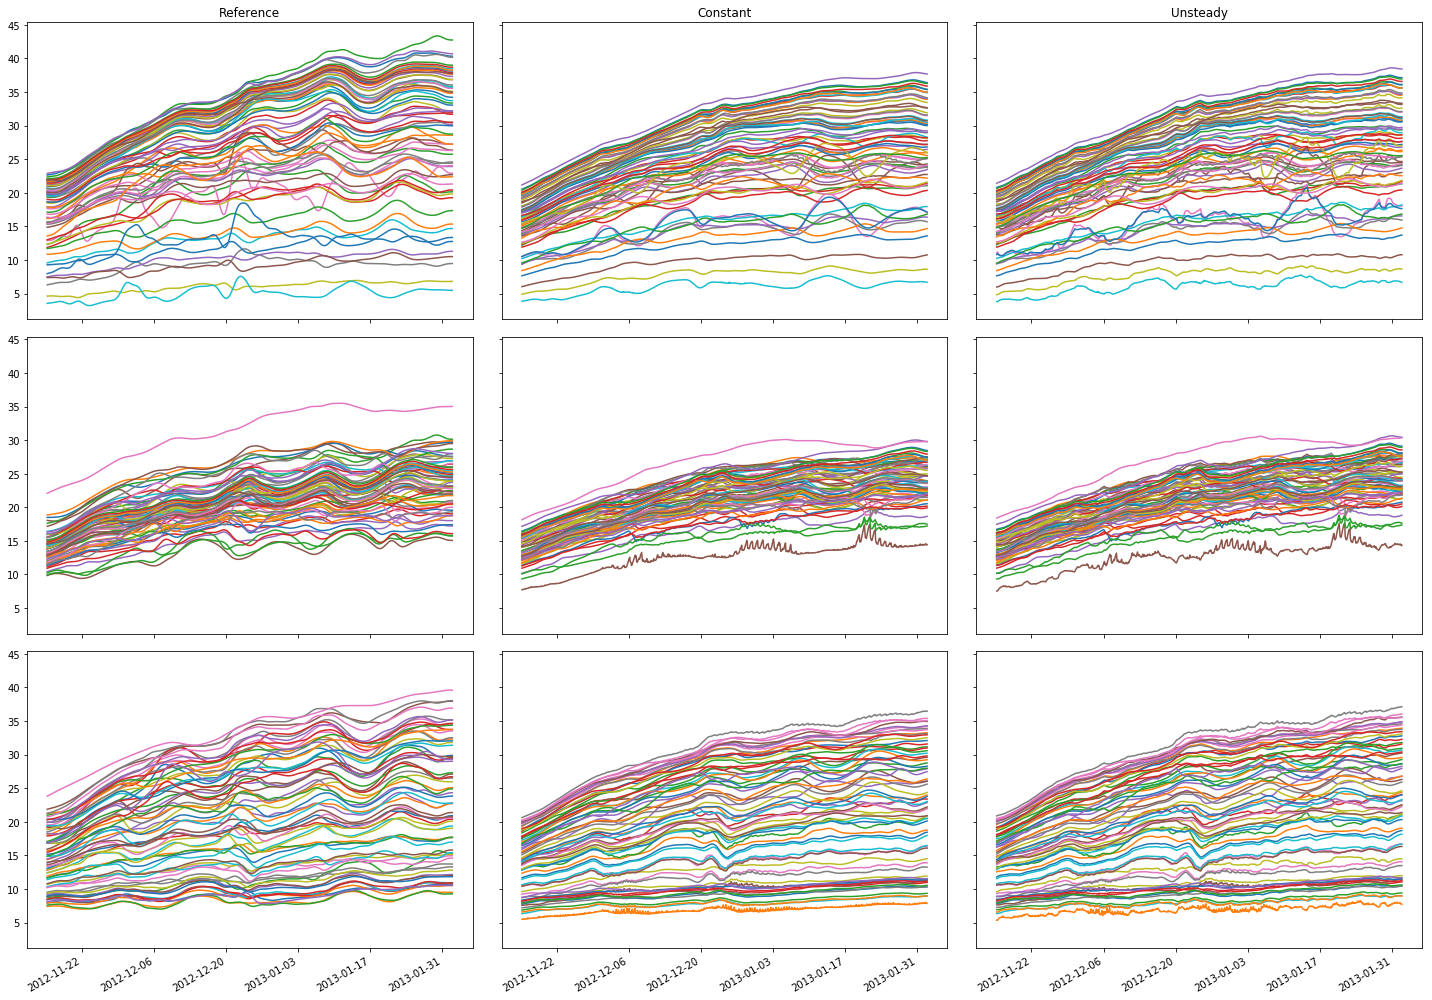

In [41]:
fig,axs=plt.subplots(len(ages),1+len(tracers),sharex=True,sharey=True,figsize=(20,14))

styles=['--',':']

ref_ds=orig_tracers
plot_t_slc=t_slc

from stompy import filters

for ax_row,age in zip(axs,ages):
    ref_ages=ref_ds[age].isel(face=cell_sel)
    ref_lp=filters.lowpass(ref_ages.values,cutoff=36,dt=0.5,axis=0)
    ref_ages=ref_ds[age].isel(time=plot_t_slc,face=cell_sel)
        
    # ax_row[0].plot(ref_ages.time.values,ref_ages.values,alpha=0.1)
    ax_row[0].plot(ref_ages.time.values,ref_lp[plot_t_slc])
    
    for ax,test_ds in zip(ax_row[1:],tracers):
        test_ages=test_ds[age].isel(time=plot_t_slc,face=cell_sel)
        ax.plot(test_ages.time,test_ages.values)

axs[0,0].set_title('Reference')
axs[0,1].set_title('Constant')
axs[0,2].set_title('Unsteady')
fig.autofmt_xdate()
fig.tight_layout()